In [126]:
#split 50% training, 20% validiation, #30% for testing (LAST PART)
# NORMALISE VERYTHGINT TO BETWEEN 0 and 1
# 

In [127]:
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
# import datetime as dt

# FULL DATA SET
model_failures = pd.read_csv(r'Failure_modelling\Failure_Data\failure_full.csv', index_col=0)
model_pipes = pd.read_csv(r'Failure_modelling\Failure_Data\pipes_full.csv', index_col=0)

from sklearn.model_selection import train_test_split

failure_training, failure_test = train_test_split(model_failures, test_size=0.2, random_state=42)
pipe_train, pipe_test = train_test_split(model_pipes, test_size=0.2, random_state=42)


pipe_train.Aanlegjaar = pd.to_datetime(pipe_train.Aanlegjaar, format='%Y')

failure_training.storing_melddatum = pd.to_datetime(failure_training.storing_melddatum)
failure_training.storing_aanlegjaar = pd.to_datetime(failure_training.storing_aanlegjaar)
failure_train = failure_training[failure_training.storing_melddatum.dt.year < 2019]

pipe_test = pipe_test[pipe_test.Aanlegjaar > 1]
pipe_test = pipe_test[pipe_test.Diameter <= 160]
pipe_test.Aanlegjaar = pd.to_datetime(pipe_test.Aanlegjaar, format='%Y')

failure_test.storing_melddatum = pd.to_datetime(failure_test.storing_melddatum)
failure_test.storing_aanlegjaar = pd.to_datetime(failure_test.storing_aanlegjaar)


failures_2019 = failure_test[failure_test.storing_melddatum.dt.year == 2019]
failure_test = failure_test[failure_test.storing_melddatum.dt.year < 2019]
failure_test = failure_test[failure_test.storing_diameter <= 160]

In [128]:
failure_rate_years = {}
for year in range(2010, 2019):
    failures_in_year = failure_train[failure_train.storing_melddatum.dt.year == year]
    failures_count_age_diameter = pd.DataFrame(failures_in_year.groupby(['age_at_failure', 'Diameter_group'])['storing_materiaal'].count()).reset_index()
    failures_count_age_diameter.rename(columns={'storing_materiaal': 'failure_count'}, inplace=True)
    
    pipe_train['age_in_year'] = year - pipe_train.Aanlegjaar.dt.year
    pipes_sum_length_age_diameter = pd.DataFrame(pipe_train.groupby(['age_in_year', 'Diameter_group'])['Lengte'].sum() / 1000).reset_index()
    failure_overview = pd.merge(failures_count_age_diameter, pipes_sum_length_age_diameter, left_on=['age_at_failure', 'Diameter_group'], right_on=['age_in_year', 'Diameter_group'], how='left')
    failure_overview.drop(['age_in_year'], axis=1, inplace=True)
    failure_overview['failure_rate_age'] = failure_overview['failure_count'] / failure_overview['Lengte']
    failure_rate_years[year] = failure_overview
    

In [129]:
all_failure_rate_years = pd.DataFrame()

for i, key in enumerate(failure_rate_years.keys()):
    if all_failure_rate_years.empty:
        all_failure_rate_years = failure_rate_years[key][["age_at_failure", "Diameter_group", "failure_rate_age"]].copy()
    else:
        all_failure_rate_years = pd.merge(
            all_failure_rate_years, 
            failure_rate_years[key][["age_at_failure", "Diameter_group", "failure_rate_age"]], 
            how="outer", 
            on=["age_at_failure", "Diameter_group"], 
            suffixes=('', f'_{key}')
        )

all_failure_rate_years.rename(columns={"failure_rate_age": "failure_rate_age_2010"}, inplace=True)

all_failure_rate_years.sort_values(by='Diameter_group', inplace=True)
all_failure_rate_years.sort_values(by='age_at_failure', inplace=True)
all_failure_rate_years.reset_index(inplace=True)
all_failure_rate_years.drop('index', axis=1, inplace=True)

all_failure_rate_years

,age_at_failure,Diameter_group,failure_rate_age_2010,failure_rate_age_2011,failure_rate_age_2012,failure_rate_age_2013,failure_rate_age_2014,failure_rate_age_2015,failure_rate_age_2016,failure_rate_age_2017,failure_rate_age_2018
0,21.0,0 - 160,NaN,NaN,0.009059,NaN,NaN,NaN,NaN,NaN,NaN
1,21.0,160 - 300,NaN,0.017026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22.0,0 - 160,0.027909,0.012230,0.017372,0.009059,NaN,NaN,NaN,NaN,NaN
3,22.0,160 - 300,0.042577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23.0,0 - 160,NaN,NaN,NaN,0.017372,0.009059,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96,75.0,0 - 160,0.068902,NaN,NaN,0.833703,NaN,NaN,NaN,NaN,NaN
97,77.0,0 - 160,NaN,NaN,NaN,NaN,NaN,0.833703,NaN,NaN,NaN
98,78.0,160 - 300,NaN,NaN,NaN,0.064396,NaN,NaN,NaN,NaN,NaN
99,78.0,0 - 160,NaN,NaN,NaN,NaN,NaN,0.077004,NaN,NaN,NaN


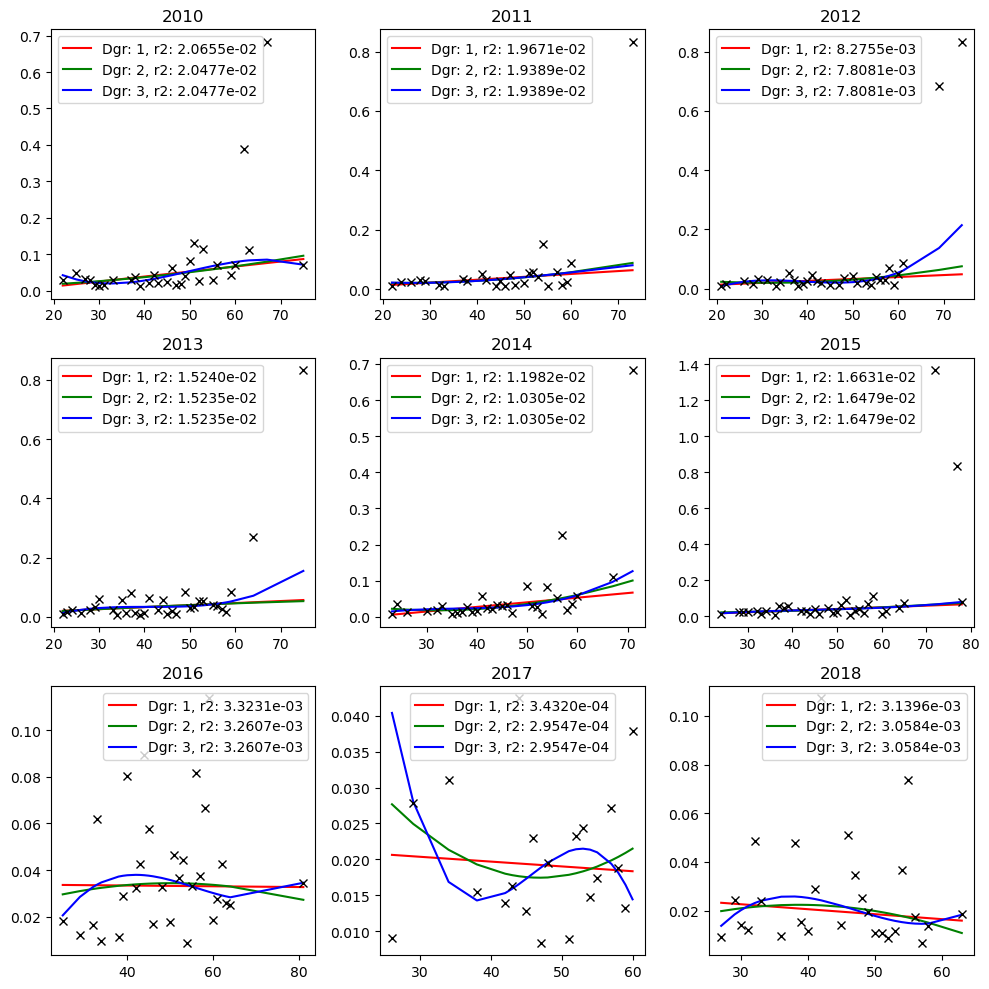

In [130]:
house_connection = all_failure_rate_years[all_failure_rate_years.Diameter_group == '0 - 160']

coefficients = []
degree_1 = []
degree_2 = []
degree_3 = []
i = 1
plt.figure(figsize=(10, 10))
for year in range(2010, 2019):
    coefficients.append({})
    ax = plt.subplot(3,3,i)
    data = house_connection.dropna(subset=[f'failure_rate_age_{year}']).copy()
    x_original = data['age_at_failure'].values
    
    # IGNORE OUTLIERS FOR POLYNOMIAL!
    mean = data[f'failure_rate_age_{year}'].mean()
    std = data[f'failure_rate_age_{year}'].std()
    lower_bound = mean - std
    upper_bound = mean + std
    
    data = data[(data[f'failure_rate_age_{year}'] >= lower_bound) & (data[f'failure_rate_age_{year}'] <= upper_bound)].copy()
    
    x = data['age_at_failure']
    y = data[f'failure_rate_age_{year}']
    
    coef1, r1, rank1, s1, rcond1 = np.polyfit(x, y , 1, full=True)
    coefficients[i - 1]['Degree 1'] = coef1
    coefficients[i - 1]['Residual 1'] = r1
    degree_1.append(coef1)
    ax.plot(x_original, np.poly1d(np.polyfit(x, y , 1))(x_original), 'r', label=f'Dgr: {1}, r2: {r1[0]:.4e}')
    
    coef2, r2, rank2, s2, rcond2 = np.polyfit(x, y , 2, full=True)
    coefficients[i - 1]['Degree 2'] = coef2
    coefficients[i - 1]['Residual 2'] = r2
    degree_2.append(coef2)
    ax.plot(x_original, np.poly1d(np.polyfit(x, y , 2))(x_original), 'g', label=f'Dgr: {2}, r2: {r2[0]:.4e}')
 
    coef3, r3, rank3, s3, rcond3 = np.polyfit(x, y , 3, full=True)
    coefficients[i - 1]['Degree 3'] = coef3
    coefficients[i - 1]['Residual 3'] = r3
    degree_3.append(coef3)
    ax.plot(x_original, np.poly1d(np.polyfit(x, y , 3))(x_original), 'b', label=f'Dgr: {3}, r2: {r2[0]:.4e}')    
    
    ax.plot(house_connection.age_at_failure, house_connection[f'failure_rate_age_{year}'], 'kx')
    plt.title(f'{year}')
    ax.legend()
    i += 1
plt.tight_layout()



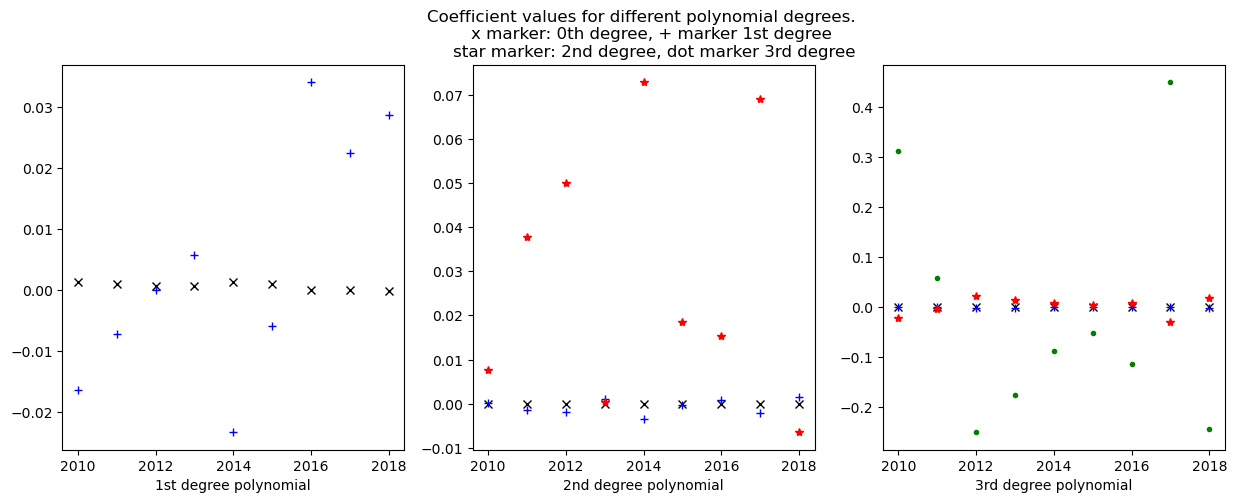

In [131]:
markers = ['x', '+', '*', '.']
colors = ['k', 'b', 'r', 'g']
plt.figure(figsize=(15,5))
for i, year in enumerate(range(2010, 2019)):
    ax1 = plt.subplot(1,3,1)
    for j, degree in enumerate(degree_1[i]):
        plt.plot(year, degree, marker=markers[j], color=colors[j])
    ax2 = plt.subplot(1,3,2)
    for j, degree in enumerate(degree_2[i]):
        plt.plot(year, degree, marker=markers[j], color=colors[j])
    ax3 = plt.subplot(1,3,3)
    for j, degree in enumerate(degree_3[i]):
        plt.plot(year, degree, marker=markers[j], color=colors[j]) 
ax1.set_xlabel('1st degree polynomial')
ax2.set_xlabel('2nd degree polynomial')
ax3.set_xlabel('3rd degree polynomial')
ax2.set_title(f'Coefficient values for different polynomial degrees. \n\
    x marker: 0th degree, + marker 1st degree \n\
    star marker: 2nd degree, dot marker 3rd degree');

In [132]:
failure_prediction_year = {}
actual_failures = []
predicted_failures_1 = []
predicted_failures_2 = []
predicted_failures_3 = []
for i, year in enumerate(range(2010, 2019)):
    failures_in_year = failure_test[failure_test.storing_melddatum.dt.year == year]
    failures_count_age_diameter = pd.DataFrame(failures_in_year.groupby(['age_at_failure'])['storing_materiaal'].count()).reset_index()
    failures_count_age_diameter.rename(columns={'storing_materiaal': 'failure_count'}, inplace=True)
    
    pipe_test['age_at_failure'] = year - pipe_test.Aanlegjaar.dt.year
    pipes_sum_length_age_diameter = pd.DataFrame(pipe_test.groupby(['age_at_failure'])['Lengte'].sum() / 1000).reset_index()
    
    failure_overview = pd.merge(failures_count_age_diameter, pipes_sum_length_age_diameter, how='outer', on='age_at_failure')
    failure_overview.sort_values('age_at_failure', inplace=True)
    failure_overview = failure_overview.dropna(subset=['Lengte'])
    failure_prediction_year[year] = failure_overview
    
    x = failure_prediction_year[year].age_at_failure.values
    y_1 = np.poly1d(degree_1[i])(x)
    y_2 = np.poly1d(degree_2[i])(x)
    y_3 = np.poly1d(degree_3[i])(x)
    
    predicted_failures_1.append(np.around(np.sum(y_1 * failure_prediction_year[year].Lengte)))
    predicted_failures_2.append(np.around(np.sum(y_2 * failure_prediction_year[year].Lengte)))
    predicted_failures_3.append(np.around(np.sum(y_3 * failure_prediction_year[year].Lengte)))
    actual_failures.append(failure_prediction_year[year].failure_count.sum())
 
failures_modelled = pd.DataFrame({'actual': actual_failures,
                                'predicted_1': predicted_failures_1,
                                'predicted_2': predicted_failures_2,          
                                'predicted_3': predicted_failures_3}, index=np.arange(2010, 2019))
failures_modelled
#Predicted failure highly dependent on tail of model. Skewed by outliers.

,actual,predicted_1,predicted_2,predicted_3
2010,17.0,27.0,28.0,30.0
2011,8.0,23.0,24.0,24.0
2012,22.0,20.0,20.0,23.0
2013,27.0,25.0,25.0,28.0
2014,18.0,23.0,25.0,26.0
2015,15.0,25.0,25.0,25.0
2016,18.0,24.0,24.0,24.0
2017,4.0,14.0,16.0,10.0
2018,12.0,14.0,13.0,16.0


In [133]:
predicted_failures_1 = []
predicted_failures_2 = []
predicted_failures_3 = []

pipe_test['age_at_failure'] = 2019 - pipe_test.Aanlegjaar.dt.year
pipes_sum_length_age = pd.DataFrame(pipe_test.groupby(['age_at_failure'])['Lengte'].sum() / 1000).reset_index()
x = pipes_sum_length_age.age_at_failure.values
y_1 = np.mean(np.poly1d(degree_1[i])(x))
y_2 = np.mean(np.poly1d(degree_2[i])(x))
y_3 = np.mean(np.poly1d(degree_3[i])(x))

predicted_failures_1.append(np.around(np.sum(y_1 * pipes_sum_length_age.Lengte)))
predicted_failures_2.append(np.around(np.sum(y_2 * pipes_sum_length_age.Lengte)))
predicted_failures_3.append(np.around(np.sum(y_3 * pipes_sum_length_age.Lengte)))

actual_failures = len(failures_2019)

failures_modelled_2019 = pd.DataFrame({'actual': actual_failures,
                                'predicted_1': predicted_failures_1,
                                'predicted_2': predicted_failures_2,          
                                'predicted_3': predicted_failures_3}, index=[2019])

failures_modelled_2019

,actual,predicted_1,predicted_2,predicted_3
2019,10,13.0,9.0,26.0


In [134]:
all_predictions = pd.concat([failures_modelled, failures_modelled_2019])
all_predictions

,actual,predicted_1,predicted_2,predicted_3
2010,17.0,27.0,28.0,30.0
2011,8.0,23.0,24.0,24.0
2012,22.0,20.0,20.0,23.0
2013,27.0,25.0,25.0,28.0
2014,18.0,23.0,25.0,26.0
2015,15.0,25.0,25.0,25.0
2016,18.0,24.0,24.0,24.0
2017,4.0,14.0,16.0,10.0
2018,12.0,14.0,13.0,16.0
2019,10.0,13.0,9.0,26.0


In [135]:

def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

df = all_predictions

rmse_values = pd.DataFrame({
    'actual': np.nan,
    'predicted_1': calculate_rmse(df['actual'], df['predicted_1']),
    'predicted_2': calculate_rmse(df['actual'], df['predicted_2']),
    'predicted_3': calculate_rmse(df['actual'], df['predicted_3']),
}, index=['RMSE'])


df = pd.concat([df, rmse_values])

def calculate_row_rmse(row):
    return np.sqrt(np.mean([
        (row['actual'] - row['predicted_1']) ** 2,
        (row['actual'] - row['predicted_2']) ** 2,
        (row['actual'] - row['predicted_3']) ** 2
    ]))

df['RMSE'] = df.apply(calculate_row_rmse, axis=1)

df

,actual,predicted_1,predicted_2,predicted_3,RMSE
2010,17.0,27.00000,28.000000,30.00000,11.401754
2011,8.0,23.00000,24.000000,24.00000,15.673757
2012,22.0,20.00000,20.000000,23.00000,1.732051
2013,27.0,25.00000,25.000000,28.00000,1.732051
2014,18.0,23.00000,25.000000,26.00000,6.782330
2015,15.0,25.00000,25.000000,25.00000,10.000000
2016,18.0,24.00000,24.000000,24.00000,6.000000
2017,4.0,14.00000,16.000000,10.00000,9.660918
2018,12.0,14.00000,13.000000,16.00000,2.645751
2019,10.0,13.00000,9.000000,26.00000,9.416298
